In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import datetime

**Choice of model: Classic LSTM**

LSTM can learn and remember patterns in the price data over time pretty well since it's able to capture temporal dependencies in the time series data as compared to other models such as linear regression.


In [ ]:
# NVIDIA dataset
df = yf.download(
    'NVDA',
    '2015-01-01',
    '2023-10-21'
)

df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,5.032500,5.070000,4.952500,5.032500,4.833229,11368000
2015-01-05,5.032500,5.047500,4.925000,4.947500,4.751597,19795200
2015-01-06,4.955000,4.960000,4.792500,4.797500,4.607534,19776400
2015-01-07,4.832500,4.875000,4.770000,4.785000,4.595530,32180800
2015-01-08,4.840000,4.995000,4.837500,4.965000,4.768404,28378000
...,...,...,...,...,...,...
2023-10-16,450.630005,462.250000,449.119995,460.950012,460.950012,37509900
2023-10-17,440.000000,447.540009,424.799988,439.380005,439.380005,81233300
2023-10-18,425.910004,432.190002,418.250000,421.959991,421.959991,62729400


In [ ]:
# Get the number of rows & columns in the dataset
df.shape

(2216, 6)

Text(0.5, 1.0, 'NVDA Closing Price History')

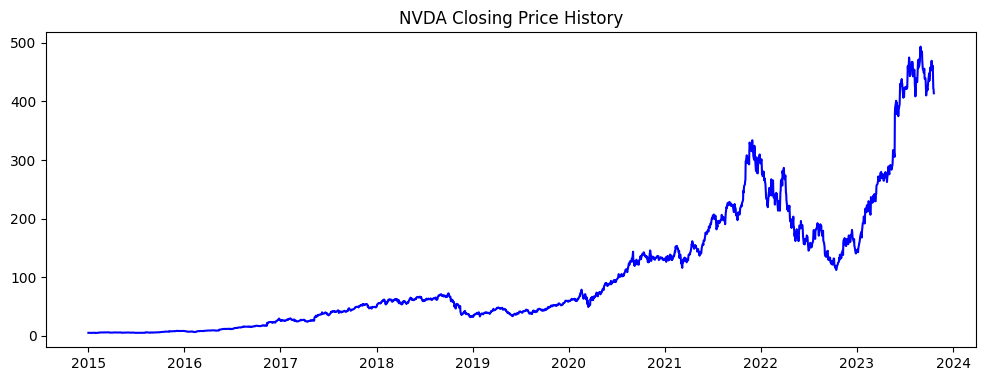

In [ ]:
# Plotting the stock closing price of NVIDIA from 2015 to 2023
plt.figure(figsize = (12,9))
plt.subplot(2,1,1)
plt.plot(df['Close'], color = 'blue')
plt.title('NVDA Closing Price History')

In [ ]:
# Create a new df with only the 'Close' column
data = df.filter(['Close'])

# Convert the df to a numpy array
dataset = data.values

# Get the number of rows to train the model on
train_data_len = math.ceil(len(dataset) * 0.8)
train_data_len

1773

In [ ]:
dataset[:15]

array([[5.03249979],
       [4.94750023],
       [4.79750013],
       [4.78499985],
       [4.96500015],
       [4.98500013],
       [4.92250013],
       [4.91499996],
       [4.93499994],
       [4.9000001 ],
       [4.98999977],
       [5.00500011],
       [5.07499981],
       [5.1624999 ],
       [5.17749977]])

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[5.06378216e-04],
       [3.32471403e-04],
       [2.55752487e-05],
       ...,
       [8.53528796e-01],
       [8.51585159e-01],
       [8.36976881e-01]])

In [ ]:
# Create the scaled train dataset
train_data = scaled_data[0:train_data_len, :]

# Split the data into x_train and y_train datasets
x_train = []
y_train = []

for i in range(20, len(train_data)):
  x_train.append(train_data[i-20:i, 0])
  y_train.append(train_data[i, 0])

In [ ]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data as the LSTM model expects the input data to be 3-dimensional (no. of samples, no. of timesteps, and no. of features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1753, 20, 1)

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(units=1, activation='linear'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=100)

Epoch 1/100
28/28 [==============================] - 15s 76ms/step - loss: 0.0079
Epoch 2/100
28/28 [==============================] - 3s 93ms/step - loss: 6.1718e-04
Epoch 3/100
28/28 [==============================] - 1s 42ms/step - loss: 3.0624e-04
Epoch 4/100
28/28 [==============================] - 2s 55ms/step - loss: 2.4648e-04
Epoch 5/100
28/28 [==============================] - 2s 58ms/step - loss: 2.5737e-04
Epoch 6/100
28/28 [==============================] - 1s 35ms/step - loss: 2.7906e-04
Epoch 7/100
28/28 [==============================] - 1s 38ms/step - loss: 2.4798e-04
Epoch 8/100
28/28 [==============================] - 1s 38ms/step - loss: 2.4595e-04
Epoch 9/100
28/28 [==============================] - 1s 36ms/step - loss: 2.5564e-04
Epoch 10/100
28/28 [==============================] - 1s 34ms/step - loss: 3.1921e-04
Epoch 11/100
28/28 [==============================] - 1s 36ms/step - loss: 2.7378e-04
Epoch 12/100
28/28 [==============================] - 1s 38ms/step

In [ ]:
# Create test dataset (scaled values from index 1773 to 2216)
test_data = scaled_data[train_data_len-20: , :]

# Split the data into x_test and y_test datasets
x_test = []
y_test = dataset[train_data_len: , :]

for i in range(20, len(test_data)):
  x_test.append(test_data[i-20:i, 0])

In [ ]:
# Convert test data into a numpy array
x_test = np.array(x_test)

# Reshape the test data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# Get the model's predicted close prices
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

14/14 [==============================] - 1s 9ms/step


In [ ]:
# Evaluate the model using RMSE
RMSE = np.sqrt(np.mean(((predictions-y_test)**2)))
RMSE

11.777764551743891

<ipython-input-101-bcef61fd739c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


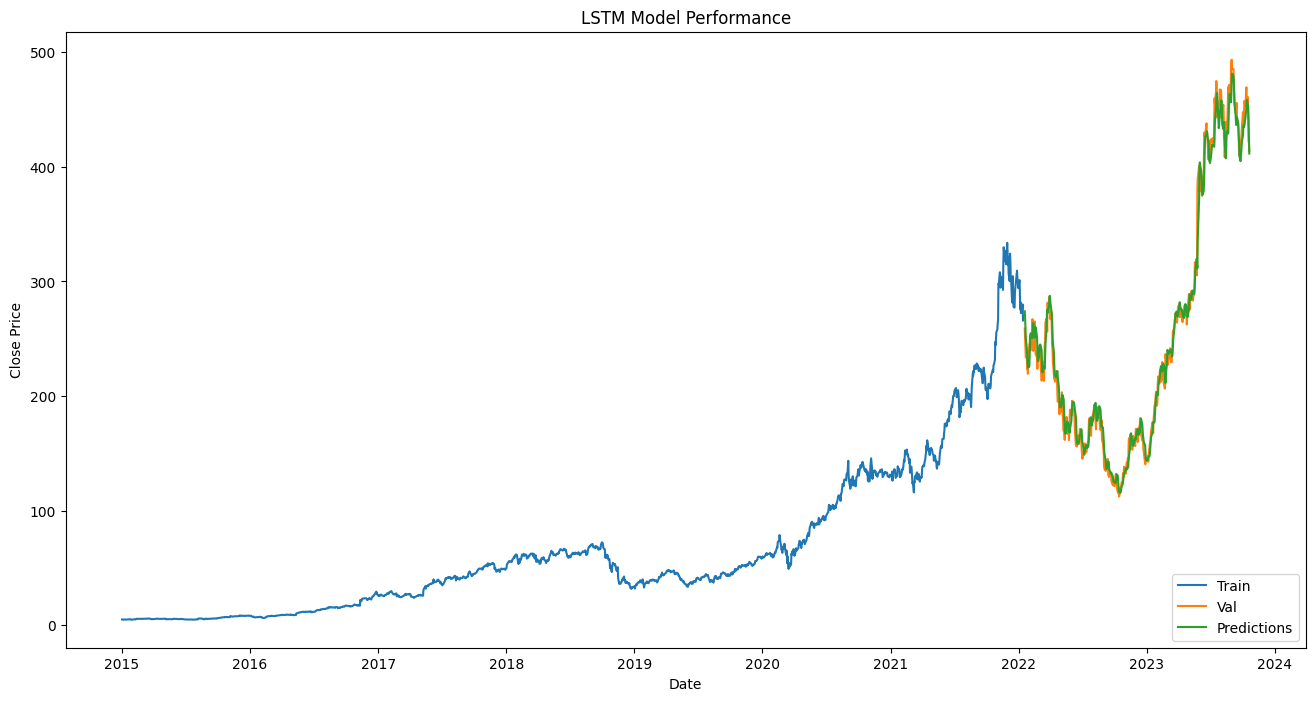

In [ ]:
# Plot the data
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions

# Visualise the data
plt.figure(figsize=(16,8))
plt.title('LSTM Model Performance')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
plt.show()

In [ ]:
# Include the validation data back into train set
x_train = []
y_train = []

for i in range(20, len(scaled_data)):
  x_train.append(scaled_data[i-20:i, 0])
  y_train.append(scaled_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data as the LSTM model expects the input data to be 3-dimensional (no. of samples, no. of timesteps, and no. of features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Train the model again
model.fit(x_train, y_train, batch_size=64, epochs=100)

Epoch 1/100
35/35 [==============================] - 1s 38ms/step - loss: 2.9012e-04
Epoch 2/100
35/35 [==============================] - 1s 34ms/step - loss: 1.7492e-04
Epoch 3/100
35/35 [==============================] - 1s 38ms/step - loss: 1.6478e-04
Epoch 4/100
35/35 [==============================] - 3s 82ms/step - loss: 1.4381e-04
Epoch 5/100
35/35 [==============================] - 2s 55ms/step - loss: 1.5858e-04
Epoch 6/100
35/35 [==============================] - 2s 49ms/step - loss: 1.4864e-04
Epoch 7/100
35/35 [==============================] - 2s 53ms/step - loss: 1.5417e-04
Epoch 8/100
35/35 [==============================] - 1s 34ms/step - loss: 1.4686e-04
Epoch 9/100
35/35 [==============================] - 1s 34ms/step - loss: 1.4455e-04
Epoch 10/100
35/35 [==============================] - 1s 36ms/step - loss: 2.5711e-04
Epoch 11/100
35/35 [==============================] - 1s 38ms/step - loss: 1.3943e-04
Epoch 12/100
35/35 [==============================] - 1s 35ms/s

In [ ]:
x_train.shape

(2196, 20, 1)

In [ ]:
# Getting the input of last 20 days before the first future day we are going to predict
future_x = scaled_data[len(scaled_data)-20: , :]
future_x=future_x.reshape(1,-1)
future_x.shape

(1, 20)

In [ ]:
# Creating a list of this input of 20 days
temp_x = list(future_x)
temp_x = temp_x[0].tolist()

In [ ]:
# Predicting the close price for the next 12 trading days (23th Oct - 7 Nov) using current data
predicted_prices = []
n_steps = 20
i = 0

while i < 12:
  if len(temp_x) > 20:
    future_x = np.array(temp_x[1:])
    future_x = future_x.reshape(1,-1)
    future_x = future_x.reshape(1, n_steps, 1)
    future_y = model.predict(future_x, verbose=0)
    temp_x.extend(future_y[0].tolist())
    temp_x = temp_x[1:]
    predicted_prices.extend(future_y.tolist())
    i += 1
  else:
    future_x = future_x.reshape(1, n_steps, 1)
    future_y = model.predict(future_x, verbose=0)
    temp_x.extend(future_y[0].tolist())
    predicted_prices.extend(future_y.tolist())
    i += 1

predicted_prices = scaler.inverse_transform(predicted_prices)
predicted_prices = predicted_prices[2:]
predicted_prices


array([[402.67513048],
       [399.16187693],
       [396.03002821],
       [393.33205224],
       [391.00607125],
       [389.01543636],
       [387.26870012],
       [385.67336634],
       [384.13996859],
       [382.63509173]])

In [ ]:
# Export the predictions to a CSV file
df = pd.DataFrame({'Close': predicted_prices.ravel()})
df.to_csv('N_Ashwin_Kumar_Project_1.csv', index=True)